<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font> 

<div class="alert alert-block alert-warning">
    
# Assignment

Welcome to task 3 of the assignment! This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook.__

<b>Enter you student details below</b>

- <b>Student Name:</b> Campbell Gregor
- <b>Student ID:</b> 33110018  

<div class="alert alert-block alert-danger">

# Table of Contents

* [Libraries](#Libraries)
    
* [Task 3.1: Download the GTSRB Train and Test set](#t3_1)
    
* [Task 3.2: Visualise a few training samples](#t3_2)
    
* [Task 3.3: Define a CNN Model](#t3_3)
    
* [Task 3.4: Train and evaluate CNN model](#t3_4)
    
* [Task 3.5: Visualise the results](#t3_5)
    
* [Task 3.6: Discussion Questions](#t3_6)

<div class="alert alert-block alert-warning">

# Libraries

Libraries are important as it saves us time from writing our own functions all the time such as graphing, or creating matrices. Brief library descriptions have been added for every library that we import. You may also check the official documentations for more details.

The required libraries are specified in this notebook for you.

In [50]:
# Mount Google Drive
import os
try:
    from google.colab import drive
    colabFlag = True
    
    PATH_DATASETS = '/content/gdrive/MyDrive/...' # Add in your own path here to the folder containing the data
    # mount Google Drive
    drive.mount('/content/gdrive')
    print(f"Using Google Colab with file path {PATH_DATASETS}")
except:
    colabFlag = False

    PATH_DATASETS = os.environ.get("PATH_DATASETS", "./Data")

    print(f"Not using Google Colab. File path will be: {PATH_DATASETS}")

Not using Google Colab. File path will be: ./Data


In [51]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import copy
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import *

import torch
import torchvision
from torchvision.datasets import GTSRB
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy, ConfusionMatrix

import pytorch_lightning as pl # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar

# from carbontracker.tracker import CarbonTracker
from torch.optim.lr_scheduler import StepLR

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


BATCH_SIZE = 256 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 0 # Set to your device

Seed set to 4179


<div class="alert alert-block alert-info">
    
# Image Classification on the GTSRB dataset
    
# What you should do in this task!

In this task you will be training a Convolutional Neural Network (CNN) with the GTSRB dataset using Pytorch and PyTorch Lightning funtionalities we have previously seen!

You have to use Pytorch inbuilt datasets, the Pytorch Lightning module class to construct MLP and CNN, and stochastic gradient descent (SGD) in order to perform training on the GTSRB dataset.
    
## In this task, you will work on the following points:
 1. Download the GTSRB Train and Test set
 2. Visualise a few training samples
 3. Define a CNN Model
 4. Train and evaluate CNN model
 5. Visualise the results and apply additional analysis here
 6. Discussion Questions

<img src="figures/GTSRB.jpg" width="700" align="center">

<div class="alert alert-block alert-info">
    
## Task 3.1: Download the GTSRB Train and Test set <a class="anchor" id="t3_1"></a>

The  German Traffic Sign Recognition Benchmark (GTSRB) is a a multi-class, single-image classification benchmark dataset. There are 43 classes in total, and more than over 50,000 images. There are 39,209 training examples, 12,630 test examples.

More about GTSRB dataset: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Pytorch has constructed a number of "dataset" classes that will automatically download various datasets making it very easy for us to train our models.

In [52]:
# Define transform to convert image into a Tensor
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Init Train DataLoader from GTSRB Dataset
train_ds = GTSRB(PATH_DATASETS, split="train", download=True, transform=transform)

# Perform Random Split for training and validation
train_ds, val_ds = random_split(train_ds, [int(len(train_ds)-math.floor(len(train_ds)*0.2)), math.ceil(int(len(train_ds)*0.2))])

val_loader = DataLoader(val_ds, shuffle=False, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True) 
train_loader = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True) 

# Init Test DataLoader from GTSRB Dataset
test_ds = GTSRB(PATH_DATASETS, split="test", download=True, transform=transform)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True) 

# Read the categories from the text file given: gtsrb_classes.txt
# This contains all 43 classes
with open(PATH_DATASETS + "/gtsrb_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# The code has been done for you in 3.1 

<div class="alert alert-block alert-info">
    
## Task 3.2: Visualise a few training samples <a class="anchor" id="t3_2"></a>
Let's first take a closer look at the shapes of the dataset, and then visualise the mini-batches that the dataloader gives us. Ensure you have reversed the normalization before plotting.

Batch images shape: torch.Size([64, 3, 28, 28])
Batch labels shape: torch.Size([64])


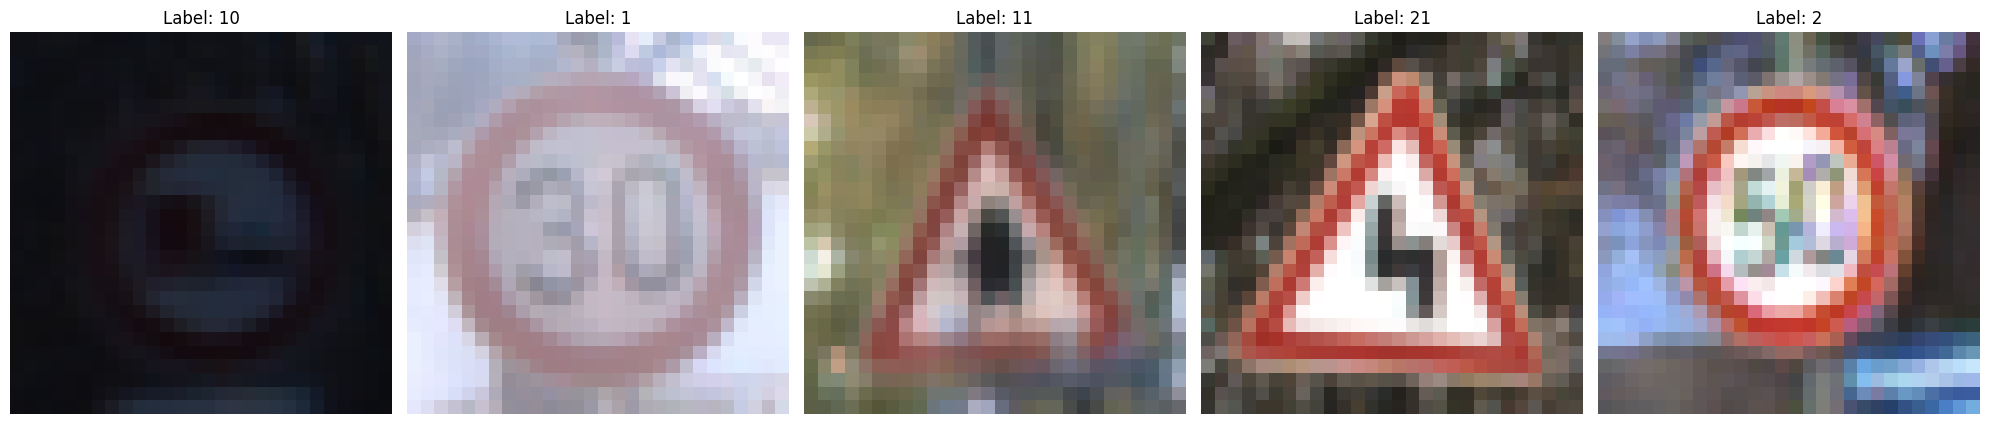

In [53]:
# Check the shapes of the batch data in train_loader

for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break  # We only need to check one batch


# Check a few images of some images
# Ensure you have inverse the normalization before plotting.
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

plt.figure(figsize = (20,10))
images, labels = next(iter(train_loader))

for i in range(5):  # Display 5 images
    ax = plt.subplot(1, 5, i + 1)
    img = images[i] * std + mean
    img = img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    plt.imshow(img)
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    
## Task 3.3: Define a CNN Model <a class="anchor" id="t3_3"></a>
    
Define the models using the LightningModule class as usual.

In [54]:
# We will use modular convolutional blocks. 
# Define a convolutional layer along with an activation function
# Remember, you can use other techniques you have learnt from the lectures and workshops such as dropout, batchnorm, pooling etc.

class ConvBlock(nn.Module):

    def __init__(self, channels_in, channels_out):
        super(ConvBlock, self).__init__()     # Call constructor
        self.conv = nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(channels_out)
        self.lrelu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
        x = self.pool(x)
        
        return x

#Let's create a simple CNN for image classification
class Simple_CNN(pl.LightningModule):
    
    def __init__(self, num_classes=43, learning_rate=1e-3):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()
        
        # Initialise at least 2 convolutional blocks with
        self.conv_blk1 = ConvBlock(3, 32)
        self.conv_blk2 = ConvBlock(32, 64)
        self.conv_blk3 = ConvBlock(64, 128)
        self.conv_blk4 = ConvBlock(128, 256)
        
        # You can use other layers too, feel free to define them here
        self.fc1 = nn.Linear(256 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # You will need to define your fully connected layer:
        

        # Define your accuracies        
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        
        
    def forward(self, x):
        x = self.conv_blk1(x)
        x = self.conv_blk2(x)
        x = self.conv_blk3(x)
        x = self.conv_blk4(x)
        # Flatten
        x = x.view(x.size(0), -1)
        x = nn.functional.leaky_relu(self.fc1(x),0.1)
        x = self.fc2(x)
        
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.train_acc(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.val_acc(y_hat, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_acc, on_epoch=True, prog_bar=True)
        
        

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        self.test_acc(y_hat, y)
        self.log('test_acc', self.test_acc, on_epoch=True)
        

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

    ##########
    # DATA RELATED HOOKS
    ##########

    def train_dataloader(self):
        return train_loader
    def val_dataloader(self):
        return val_loader
    def test_dataloader(self):
        return test_loader

<div class="alert alert-block alert-info">
    
## Task 3.4: Train and evaluate CNN model <a class="anchor" id="t3_4"></a>
    
Define VisualizeSamplePredictionsCallback using Callback class. You have to visualise 4 sample predictions from the first batch at the end of testing. This will redefine the on_test_batch_end function.

Here is a sample image:
    
<img src="figures/sample_predictions_reel.png" width="700" align="center">

Make sure to display actual category of Ground truth and Prediction by reading the given text file.
   
    
In PyTorch Lightning, callback functions are used to customize and extend the behavior of your training loops without cluttering your main code. Callbacks are objects that you can attach to your LightningModule and customize various aspects of the training process, such as logging, early stopping, model checkpointing, and more. We are updating the callback of the  the _on_test_batch_end method derived from the pytorch lightning module.

In [55]:
class VisualizeSamplePredictionsCallback(Callback):
    
    def on_test_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx):
        """Called when the test batch ends."""
        
        def denormalize(self, tensor):
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            return tensor * std + mean
        # `outputs` comes from `LightningModule.test_step`, so make sure to return prediction in test_step 
        # which corresponds to our model predictions during testing time in this case
        # Let's log 4 sample image predictions from first batch
        # Make sure to do inverse normalizing before you plot original images
        # Also, make sure to display corresponding actual class name for ground truth and prediction
        
        # You can ignore the input "dataloader_id"
        if batch_idx == 0:

            x, y = batch
            y_hat = outputs
            # # If you are using cuda, then you need to use the three lines below
            # x = x.cpu() 
            # y = y.cpu()
            # outputs = outputs.cpu()

            fig, ax = plt.subplots(1, 4, figsize=(20, 20))
            
            # Apply your inverse normalization before plotting
            for i in range(4):
                img = self.denormalize(x[i])
                img = img.permute(1, 2, 0).numpy()

                pred_class = torch.argmax(y_hat[i]).item()
                true_class = y[i].item()

                ax[i].imshow(img)
                ax[i].set_title(f"True: {self.categories[true_class]}\nPred: {self.categories[pred_class]}")
                ax[i].axis('off')

            plt.show()

In [61]:
# Initialize the CNN model
max_epochs = 40 # Feel free to change this
model_cnn = Simple_CNN()

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_section_3/",
        save_top_k=1,        
        mode="min",
        every_n_epochs=1
    )

# Stop after 5 epochs of no improvement in validation loss
early_stopping = EarlyStopping('val_loss', patience = 5, mode='min') 

# Call the Trainer and train the model
trainer_task = pl.Trainer(
    accelerator="auto",
    #devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=max_epochs,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback],
    logger=CSVLogger(save_dir="logs_task_3"),
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [60]:
# Train the model
#trainer_task.fit(model_cnn)
checkpoint = torch.load("checkpoints_section_3\epoch=39-step=13320.ckpt")
model_cnn.load_state_dict(checkpoint['state_dict'])


C:\Users\cgreg\AppData\Local\Temp\ipykernel_22320\3647889575.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints_section_3\epoch=39-step

<All keys matched successfully>

In [58]:
# Test the model and report test accuracy and test loss
trainer_task.test(model_cnn)

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8823436498641968
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8823436498641968}]

<div class="alert alert-block alert-info">
    
## Task 3.5: Visualise the results and apply additional analysis here <a class="anchor" id="t3_5"></a>

Using log files and matplotlib, plot train loss, validation loss, train accuracy, and validation accuracy.

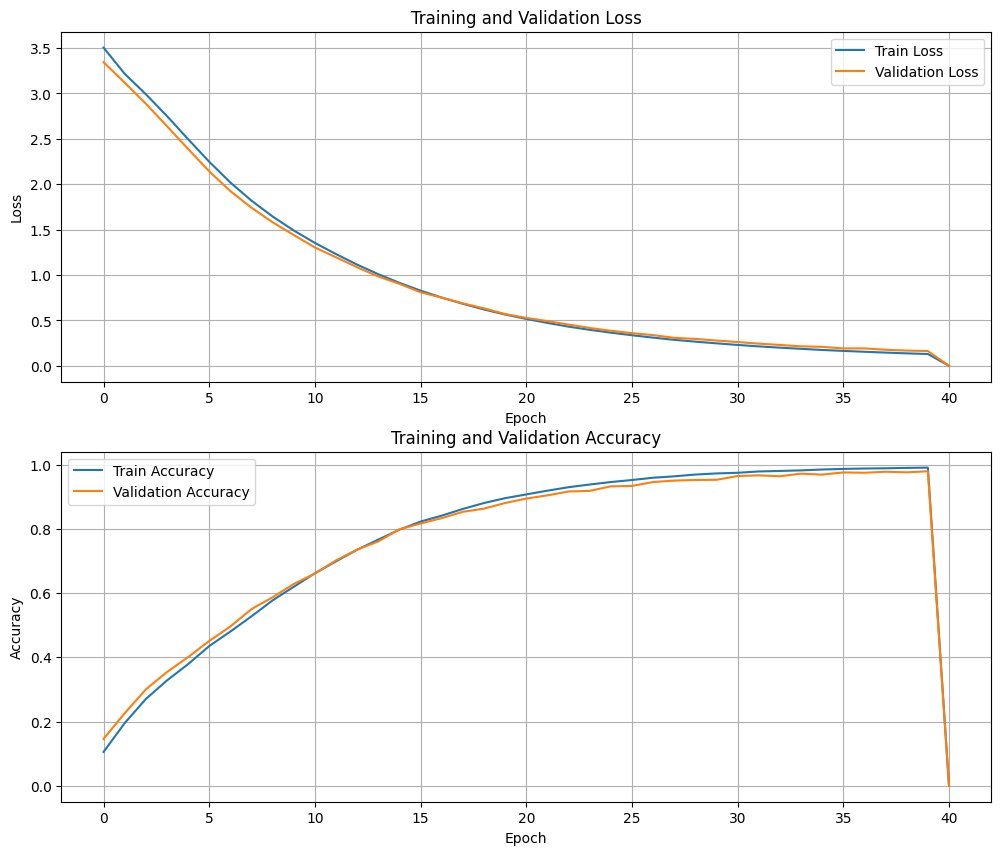

In [22]:

# Show the CNN training and validation curves.
# You can use your own way of logging if you do not want to use tensorboard.
metrics_task = pd.read_csv("./logs_task_3/lightning_logs/version_0/metrics.csv")
metrics_task.set_index("epoch", inplace=True)
metrics_task = metrics_task.groupby(level=0).sum().drop("step", axis=1)
#print(metrics_task.keys())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot Loss
ax1.plot(metrics_task.index, metrics_task['train_loss_epoch'], label='Train Loss')
ax1.plot(metrics_task.index, metrics_task['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot Accuracy
ax2.plot(metrics_task.index, metrics_task['train_acc_epoch'], label='Train Accuracy')
ax2.plot(metrics_task.index, metrics_task['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)


Add in your other analysis here. You can choose two (or more) of the following (or any others that are not on this list):

- Feature maps at the outputs of each __CNN block__ for a correctly classified road sign
- Saliency map on a correctly classified road sign
- Top 5 incorrectly classified road signs
- Occlusion sensitivity on a few images
- Confusion matrix on a subset of classes (~15 classes)

In [64]:
# I choose Saliency Map and top 5 missclassified

test_outputs = []
test_labels = []
test_inputs = []

model_cnn.eval()

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch  
        
        # Store the inputs and labels
        test_inputs.append(inputs)
        test_labels.append(labels)

        # Get model outputs
        logits = model_cnn(inputs)
        test_outputs.append(logits)  

# Concatenate all the outputs, labels, and inputs
test_outputs = torch.cat(test_outputs, dim=0)
test_labels = torch.cat(test_labels, dim=0)
test_inputs = torch.cat(test_inputs, dim=0)


test_probs = torch.softmax(test_outputs, dim=1)
test_preds = torch.argmax(test_probs, dim=1)




First predicted label: 34


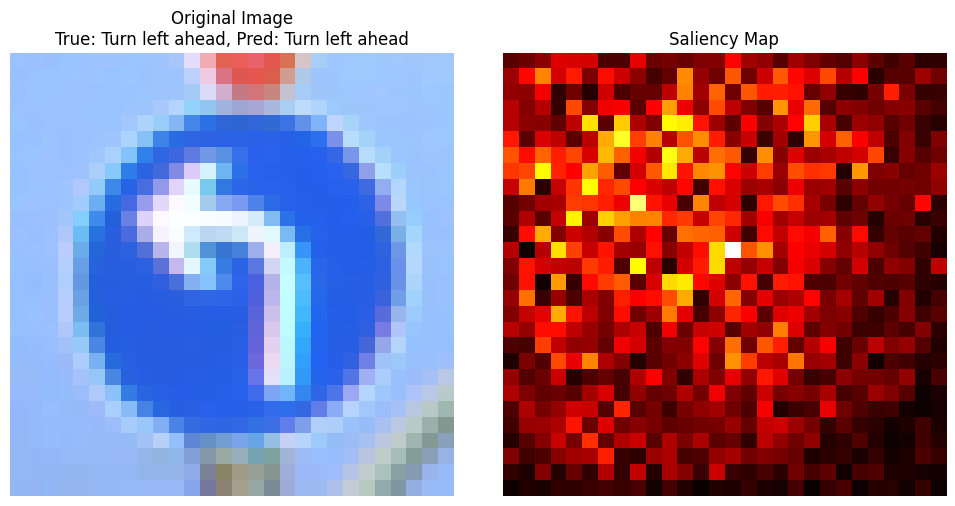

In [109]:
#Confusion Matrix
# Find indices of correctly classified test samples
correct_preds = test_preds == test_labels

# Select a random index from the correctly classified samples
correct_indices = torch.where(correct_preds)[0]
random_index = random.choice(correct_indices.tolist())

# Retrieve the input image, true label, model output, predicted label for the selected index
selected_image = test_inputs[random_index]
true_label = test_labels[random_index].item()
predicted_label = test_preds[random_index].item()

# Add a batch dimension to the input image and set requires_grad to True for saliency analysis
image = selected_image.unsqueeze(0)
image.requires_grad = True

# Compute the scores and gradients for the input image
model_cnn.eval()  # Set the model to evaluation mode
scores = model_cnn(image)
score_max = scores[0, predicted_label]
model_cnn.zero_grad()
score_max.backward()

# Calculate the saliency map
saliency, _ = torch.max(image.grad.data.abs(), dim=1)

# Create a subplot to display the original image and saliency map side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
unnormalized_image = selected_image * std + mean
unnormalized_image = unnormalized_image.permute(1, 2, 0).numpy()
axes[0].imshow(unnormalized_image)
axes[0].axis('off')
axes[0].set_title(f'Original Image\nTrue: {categories[true_label]}, Pred: {categories[predicted_label]}')

# Display the saliency map
axes[1].imshow(saliency[0].cpu(), cmap='hot')
axes[1].axis('off')
axes[1].set_title('Saliency Map')

plt.tight_layout()
plt.show()


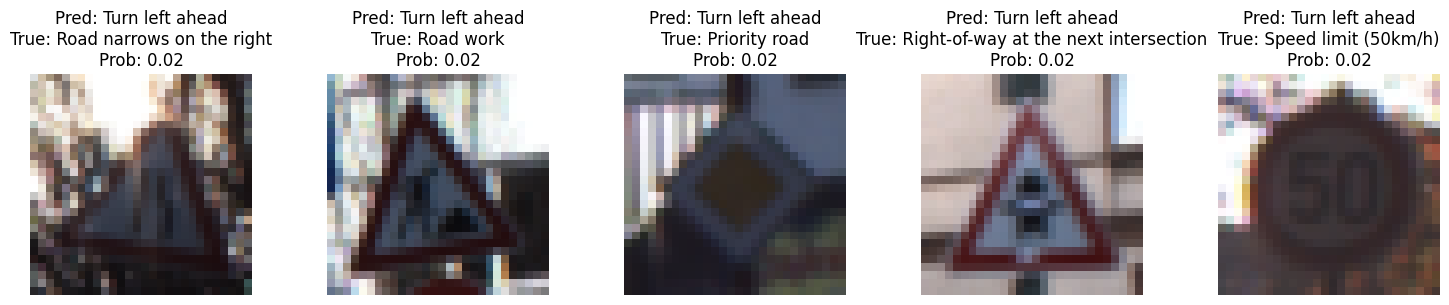

In [76]:
# top 5 Wrong Predictions

#  wrong predictions
wrong_predictions = test_preds != test_labels

# Get indices 
wrong_indices = torch.nonzero(wrong_predictions, as_tuple=True)[0]

#get the predicted labels and probabilities 
predicted_labels = test_preds[wrong_indices]
predicted_probs = test_probs[wrong_indices, predicted_labels]

# Get the top 5 
top_k_values, top_k_indices = torch.topk(predicted_probs, k=5, largest=False)
top_misclassified_indices = wrong_indices[top_k_indices]

# Plot
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, idx in enumerate(top_misclassified_indices):
    # Un-normalize the image
    image = test_inputs[idx] * std + mean  # Replace std and mean with your normalization values
    image = image.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

    
    top_class_prob = top_k_values[i].item()
    predicted_label = predicted_labels[i].item()
    true_label = test_labels[idx].item()

    
    axes[i].imshow(image)
    axes[i].set_title(f"Pred: {categories[predicted_label]}\nTrue: {categories[true_label]}\nProb: {top_class_prob:.2f}")
    axes[i].axis('off')  


plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
    
## Task 3.6: Discussion Questions <a class="anchor" id="t3_6"></a>
    
## Questions
    
1. List the different ways you have tried to optimize your model and discuss why you chose those methods.

2. Show how you calculated the input size of the fully connected layer right after all the convolutional blocks. 

3. Please talk and discuss about the first additional analysis you have performed. What can you deduce from the analysis?

4. Please talk and discuss about the second additional analysis you have performed. What can you deduce from the analysis?
    

    
## Answers

1. Initially my convolutional blocks would have a convolution -> ReLu -> Max pool. The model then had 3 convolutional blocks with 2 linear layers seperated by another Relu function. This got me to about 60% test accuracy and 85% train and Val accuracy. I added another convolutional layer and that increased the accuracies by 10-15%. I also changed the activation function to leakey ReLu wich increased the training and validation accuray to above 95% but only increasing the test accuracy a little bit. This seemed to be a sign of overfitting and after some research I added a BatchNorm layer in the convolution block wich significantly improved the test accuracy to 88%. Padding and max pooling stride didn't seem to matter much so I kept them at low numbers so calculations were easier.

2. W = H = (Input size-k+2p)/s+1 = (Input size - 3 + 2)/1 + 1 = Input size. The max pooling would just helf the input H and W each time. This made calculations easy:
ConvBlock 1:
    Input: (3,H,W)(3,H,W)
    Output: (32,H/2,W/2)(32,H/2,W/2)
ConvBlock 2:
    Input: (32,H/2,W/2)(32,H/2,W/2)
    Output: (64,H/4,W/4)(64,H/4,W/4)
ConvBlock 3:
    Input: (64,H/4,W/4)(64,H/4,W/4)
    Output: (128,H/8,W/8)(128,H/8,W/8)
ConvBlock 4:
    Input: (128,H/8,W/8)(128,H/8,W/8)
    Output: (256,H/16,W/16)(256,H/16,W/16)
For Flattening: 

3. For my first analysis I was looking at the missclassified images since I had code for that from another lab. The most misclassified images were more blurry than the rest and the model defaulted all predictions it wasn't sure of as "Turn Left Ahead". This seemed to be more of a data issue or the model needed to be trained on more blurry data to become more robust.

4. The second was the saliency map. The model seemed to focus on the key parts of the image, like the arrow in trun left ahead. I was quite happy with this.
